#### Standard GCN
As in Kipf et al. (2016)

In [12]:
import sys
import os
import time
import argparse
import pdb

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Add higher directory to python modules path.
sys.path.append("..") 
from dataloader import load_cora
from model import GCN

In [57]:
class obj(object):
    def __init__(self, d):
        for a, b in d.items():
            if isinstance(b, (list, tuple)):
               setattr(self, a, [obj(x) if isinstance(x, dict) else x for x in b])
            else:
               setattr(self, a, obj(b) if isinstance(b, dict) else b)
args = {
    'gpu': 1,
    'seed': None,
    'epochs': 500,
    'lr': 0.01,
    'wd': 5e-4,
    'layers': 2,
    'h_size': 16,
    'dropout': 0.5,
    'val_every': -1,
    'val_only': 1,
    'checkpoint': 0,
    'model': '../save/model-val-0.8233.pth',
    'log_every': 50,
    'prepro': '../../data/cora/preprocessed.pth',
    'test': 0,
}
args = obj(args)

In [58]:
# Setup
start = time.time()
args.gpu = args.gpu and torch.cuda.is_available() and False
if args.seed is not None:
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    if args.cuda:
        torch.cuda.manual_seed(args.seed)

# Data
if args.prepro:
    tmp = torch.load(args.prepro)
    adj_i, adj_v, adj_s, feats, labels, idx_train, idx_val, idx_test = tmp
    adj = torch.sparse.FloatTensor(adj_i, adj_v, adj_s)
else:
    adj, feats, labels, idx_train, idx_val, idx_test = load_cora()

In [59]:
# Model
model = GCN(num_layers=args.layers, 
            in_size=feats.shape[1],
            h_size=args.h_size, 
            out_size=labels.max().item() + 1,
            dropout=args.dropout)
if args.model:
    model.load_state_dict(torch.load(args.model))

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.wd)

# GPU
if args.gpu:
    tmp = model, adj, feats, labels, idx_train, idx_val, idx_test
    tmp = [x.cuda() for x in tmp]
    model, adj, feats, labels, idx_train, idx_val, idx_test = tmp

In [112]:
import torch.nn.functional as F 

# Data for validation/plotting 
idx = idx_test #torch.cat((idx_val, idx_test))

# Validation
model.eval()
output = model(feats, adj)
y_hat, y = (output[idx], labels[idx]) # helper
loss = F.cross_entropy(y_hat, y)
preds = y_hat.max(1)[1].type_as(y)
preds_eq = preds.eq(y)
acc = preds_eq.float().sum() / len(y)
print(acc)

tensor(0.8350)


#### Exploring
We explore the degree of uncertainty given to the incorrectly labeled data points. 

In [129]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8, 5)

In [130]:
# Extract incorrect labels
y_hat_wrong = torch.nn.functional.softmax(output[idx][preds_eq == 0], dim=1)
y_hat_right = torch.nn.functional.softmax(output[idx][preds_eq == 1], dim=1)
# y_wrong = labels[idx][preds_eq == 0]
#y_wrong_onehot = torch.eye(7)[labels[idx][preds_eq == 0]]

In [131]:
# # Some example data points
# print('--- Example 53')
# print('Prediction: ', y_hat_wrong[53].data.numpy())
# print('Label: ', y_wrong[53].item())
# print()
# print('--- Example 33')
# print('Prediction: ', y_hat_wrong[33].data.numpy())
# print('Label: ', y_wrong[33].item())

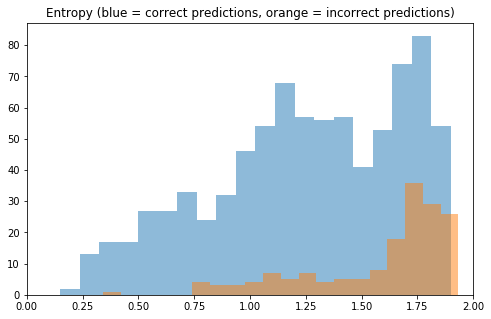

In [142]:
# The amount we are wrong for each example: 
# max predicted (wrong) class probability - the correct class probability
# amt_wrong = y_hat_wrong.max(dim=1)[0] - (y_wrong_onehot * y_hat_wrong).sum(dim=1)

entropy_wrong = -(y_hat_wrong * torch.log(y_hat_wrong)).sum(dim=1)
entropy_right = -(y_hat_right * torch.log(y_hat_right)).sum(dim=1)
plt.hist(entropy_right.detach().cpu().numpy(), bins=20, alpha=0.5)
plt.hist(entropy_wrong.detach().cpu().numpy(), bins=20, alpha=0.5)
plt.xlim(0.0,2.0)
plt.title('Entropy (blue = correct predictions, orange = incorrect predictions)')
plt.show()
# plt.hist(amt_wrong.detach().cpu().numpy(), bins=20)


In [139]:
len(idx_test)

1000